# MedARC fMRI foundation model quickstart

Example data for the tutorial can be downloaded from [huggingface](https://huggingface.co/datasets/medarc/fmri-fm.datasets).

In [1]:
from pathlib import Path

import torch
import numpy as np
from matplotlib import pyplot as plt

import models_mae
from flat_data import make_flat_wds_dataset, make_flat_transform
from util.visualization import FC_CMAP, plot_mask_pred

In [2]:
plt.rcParams["figure.dpi"] = 100

Set the directorying containing the tutorial data.

In [3]:
data_dir = Path("/data/fmri-fm.datasets")

Load a pretrained checkpoint for a ViT-S/16

In [4]:
ckpt = torch.load(data_dir / "checkpoints/fm_mae_pretrain_vit_small.pth", weights_only=True)

args = ckpt["args"]
state = ckpt["model"]

model = models_mae.__dict__[args["model"]](**args)
model.load_state_dict(state)

img_size (224, 560) patch_size (16, 16) frames 16 t_patch_size 16
model initialized


<All keys matched successfully>

Create a flat map dataset from one example webdataset shard.

In [5]:
dataset = make_flat_wds_dataset(
    str(data_dir / "hcp-flat/hcp-flat_0000.tar"),
    clipping="sequential",
    shuffle=False,
)

transform = make_flat_transform(
    img_size=(224, 560),
    clip_vmax=args["clip_vmax"],
    normalize=args["normalize"],
)

dataset = dataset.map(transform)

sample = next(iter(dataset))
print(sample.keys())
print(sample["__key__"])

dict_keys(['__key__', 'sub', 'mod', 'task', 'mag', 'dir', 'n_frames', 'image', 'start', 'mask'])
sub-349244_mod-tfMRI_task-RELATIONAL_mag-3T_dir-RL


Inspect the image data and flat map mask.

In [6]:
images = sample["image"]
img_mask = sample["mask"]
print(images.shape, images.dtype)
print(img_mask.shape, img_mask.dtype)

torch.Size([1, 16, 224, 560]) torch.float32
torch.Size([1, 1, 224, 560]) torch.float32


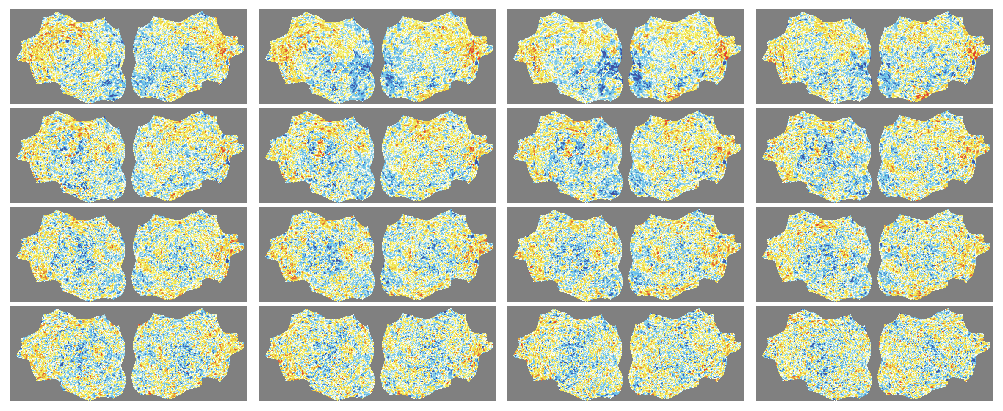

In [7]:
H, W = images.shape[2:]
ploth = 1.0
plotw = (W / H) * ploth

nr = 4
nc = 4

f, axs = plt.subplots(nr, nc, figsize=(nc * plotw, nr * ploth))
axs = axs.flatten()

for ii, ax in enumerate(axs):
    plt.sca(ax)
    img = np.where(img_mask[0, 0] > 0, images[0, ii], np.nan)
    plt.imshow(img, vmin=-3, vmax=3, cmap=FC_CMAP, interpolation="none")
    plt.axis("off")

plt.tight_layout(pad=0.3)

Run the model.

In [8]:
generator = torch.Generator()
generator.manual_seed(42)

loss, pred, mask, decoder_mask = model(
    images[None, ...],
    mask_ratio=args["mask_ratio"],
    decoder_mask_ratio=0.0,
    img_mask=img_mask[None, ...],
    generator=generator,
)

print(f"MAE MSE loss: {loss:.4f}")

MAE MSE loss: 0.8296


Generate masked reconstructions for visualization.

In [9]:
target, _, _, im_masked, im_paste, img_mask = (
    model.forward_masked_recon(images[None, ...], pred, mask, img_mask=img_mask[None, ...])
)

Visualize the masked reconstructions.

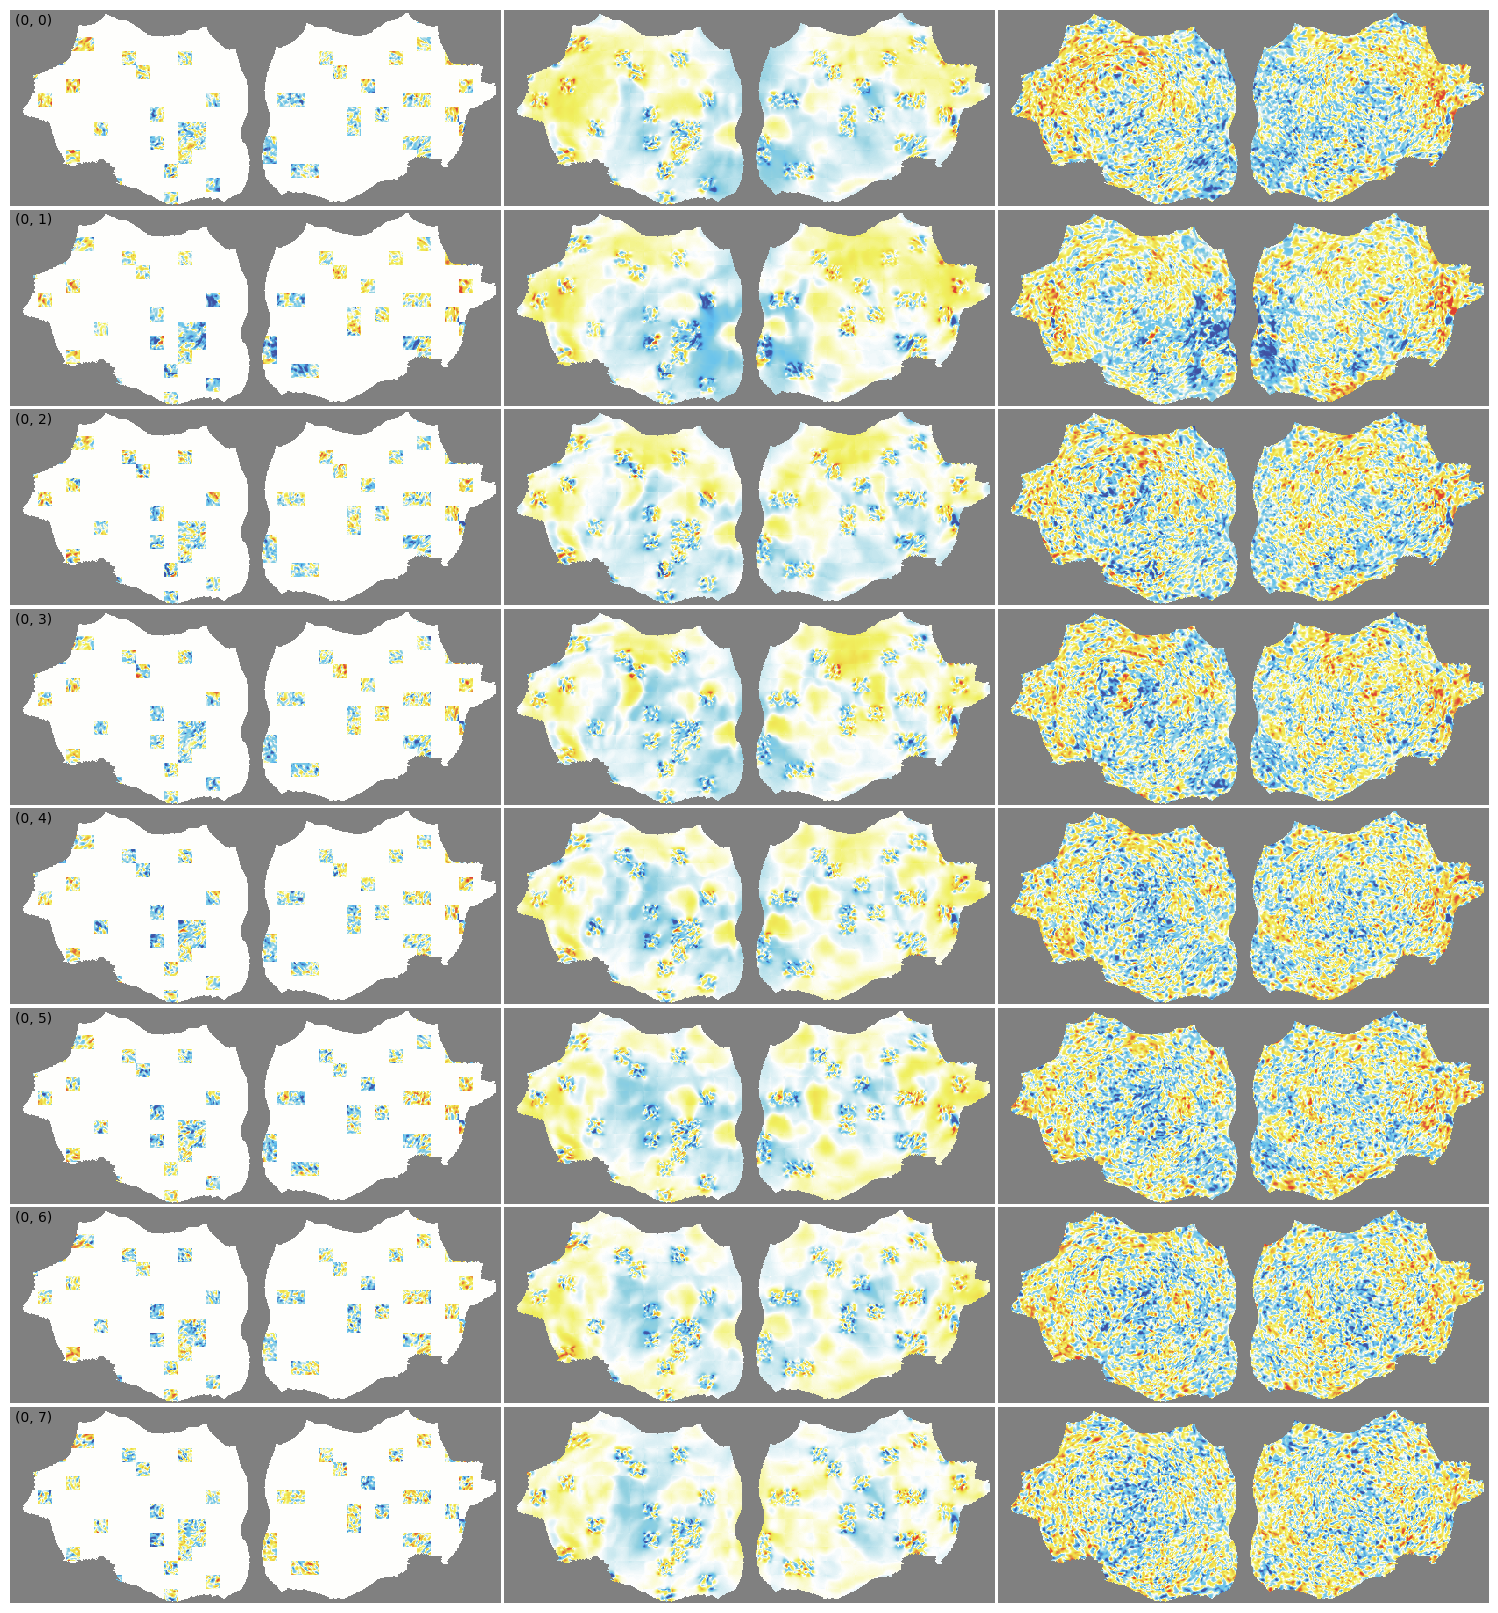

In [10]:
plot_mask_pred(target, im_masked, im_paste, img_mask=img_mask);